In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import swifter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# -------------------------
# Load Data
# -------------------------
partition_file = "data/partition.json"
with open(partition_file, "r") as f:
    partition = json.load(f)

beer_cluster_map = {int(k): v for k, v in partition.items()}

from src.data.beerdata_loader import BeerDataLoader

data_loader = BeerDataLoader(
    data_dir="../ada-2024-project-data-crusadas/data/BeerAdvocate", force_process=False
)

ba_reviews_df, ba_ratings_df, ba_beers_df, ba_breweries_df, ba_users_df = (
    data_loader.load_all_data()
)

# Add cluster information to beers
ba_beers_df["cluster"] = ba_beers_df["beer_id"].map(beer_cluster_map)

# Filter reviews to only those beers in the cluster map
ba_reviews_df = ba_reviews_df[ba_reviews_df["beer_id"].isin(beer_cluster_map.keys())]

# Drop rows without text and ensure text is a string
ba_reviews_df = ba_reviews_df.dropna(subset=["text"])
ba_reviews_df["text"] = ba_reviews_df["text"].astype(str)


Processed file '../ada-2024-project-data-crusadas/data/BeerAdvocate\reviews_processed.csv' already exists. Skipping processing.
Processed file '../ada-2024-project-data-crusadas/data/BeerAdvocate\ratings_processed.csv' already exists. Skipping processing.


In [2]:
# -------------------------
# Combine Reviews by Beer
# -------------------------
beer_texts = (
    ba_reviews_df.groupby("beer_id")["text"]
    .agg(' '.join)
    .reset_index()
)

# Merge with cluster information
beer_texts = beer_texts.merge(ba_beers_df[["beer_id", "cluster"]], on="beer_id", how="left")
beer_texts = beer_texts.dropna(subset=["cluster"])

# Convert cluster to category for efficiency
beer_texts["cluster"] = beer_texts["cluster"].astype("category")

In [3]:
# -------------------------
# Print distribution of beers by cluster
# -------------------------
cluster_counts = beer_texts["cluster"].value_counts().sort_index()
total_beers = cluster_counts.sum()

print("Distribution of beers by cluster:")
cumulative = 0
for cl, count in cluster_counts.items():
    cumulative += count
    cum_pct = (cumulative / total_beers) * 100
    print(f"Cluster {cl}: {count} beers, cumulative %: {cum_pct:.2f}%")

Distribution of beers by cluster:
Cluster 0.0: 21575 beers, cumulative %: 16.46%
Cluster 1.0: 4323 beers, cumulative %: 19.76%
Cluster 2.0: 18464 beers, cumulative %: 33.84%
Cluster 3.0: 19754 beers, cumulative %: 48.91%
Cluster 4.0: 15250 beers, cumulative %: 60.55%
Cluster 5.0: 24507 beers, cumulative %: 79.24%
Cluster 6.0: 15632 beers, cumulative %: 91.17%
Cluster 7.0: 9933 beers, cumulative %: 98.75%
Cluster 8.0: 1623 beers, cumulative %: 99.98%
Cluster 9.0: 2 beers, cumulative %: 99.98%
Cluster 10.0: 2 beers, cumulative %: 99.99%
Cluster 11.0: 2 beers, cumulative %: 99.99%
Cluster 12.0: 2 beers, cumulative %: 99.99%
Cluster 13.0: 2 beers, cumulative %: 99.99%
Cluster 14.0: 2 beers, cumulative %: 99.99%
Cluster 15.0: 2 beers, cumulative %: 99.99%
Cluster 16.0: 2 beers, cumulative %: 100.00%
Cluster 17.0: 2 beers, cumulative %: 100.00%
Cluster 18.0: 2 beers, cumulative %: 100.00%
Cluster 19.0: 2 beers, cumulative %: 100.00%


In [4]:
# -------------------------
# Keep only the first 9 clusters (0 through 8)
# -------------------------
clusters_to_keep = list(range(9))
beer_texts = beer_texts[beer_texts["cluster"].isin(clusters_to_keep)]

# IMPORTANT: Remove unused categories after filtering
beer_texts["cluster"] = beer_texts["cluster"].cat.remove_unused_categories()

# Verify distribution again after filtering
print("\nDistribution of beers by cluster after filtering (0-8):")
cluster_counts_filtered = beer_texts["cluster"].value_counts().sort_index()
total_beers_filtered = cluster_counts_filtered.sum()
cumulative = 0
for cl, count in cluster_counts_filtered.items():
    cumulative += count
    cum_pct = (cumulative / total_beers_filtered) * 100
    print(f"Cluster {cl}: {count} beers, cumulative %: {cum_pct:.2f}%")


Distribution of beers by cluster after filtering (0-8):
Cluster 0.0: 21575 beers, cumulative %: 16.46%
Cluster 1.0: 4323 beers, cumulative %: 19.76%
Cluster 2.0: 18464 beers, cumulative %: 33.85%
Cluster 3.0: 19754 beers, cumulative %: 48.92%
Cluster 4.0: 15250 beers, cumulative %: 60.56%
Cluster 5.0: 24507 beers, cumulative %: 79.26%
Cluster 6.0: 15632 beers, cumulative %: 91.18%
Cluster 7.0: 9933 beers, cumulative %: 98.76%
Cluster 8.0: 1623 beers, cumulative %: 100.00%


In [5]:
# -------------------------
# Basic Text Cleaning
# -------------------------
digits_re = re.compile(r"\d+")

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = digits_re.sub("", text)
    text = " ".join(text.split())
    return text

# Parallel cleaning
beer_texts["clean_text"] = beer_texts["text"].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/131061 [00:00<?, ?it/s]

In [6]:
# -------------------------
# TF-IDF Vectorization
# -------------------------
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.5
)

X = vectorizer.fit_transform(beer_texts["clean_text"])

In [7]:
# -------------------------
# PCA via TruncatedSVD (for sparse data)
# -------------------------
n_components = 8
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_pca = svd.fit_transform(X)

# Attach PCA components back to DataFrame
for i in range(n_components):
    beer_texts[f"PC{i+1}"] = X_pca[:, i]

In [8]:
from scipy.stats import f_oneway

# -------------------------
# ANOVA to check differences across clusters for each PC
# -------------------------
for i in range(n_components):
    pc_col = f"PC{i+1}"
    # Ensure no empty groups:
    groups = [group[pc_col].values for _, group in beer_texts.groupby("cluster")]
    # ANOVA requires that each group has data
    if all(len(g) > 0 for g in groups):
        stat, p = f_oneway(*groups)
        print(f"ANOVA for {pc_col}: F={stat:.2f}, p={p:.3e}")
    else:
        print(f"ANOVA for {pc_col}: Unable to compute (empty group).")

# Print explained variance ratios
print("\nExplained variance ratio per PC:", svd.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(svd.explained_variance_ratio_))

ANOVA for PC1: F=3245.07, p=0.000e+00
ANOVA for PC2: F=43976.03, p=0.000e+00
ANOVA for PC3: F=19742.44, p=0.000e+00
ANOVA for PC4: F=10990.35, p=0.000e+00
ANOVA for PC5: F=13986.06, p=0.000e+00
ANOVA for PC6: F=11398.37, p=0.000e+00
ANOVA for PC7: F=14270.25, p=0.000e+00
ANOVA for PC8: F=179.30, p=9.948e-303

Explained variance ratio per PC: [0.02226398 0.02605252 0.01179182 0.00950902 0.00892355 0.00662831
 0.0061859  0.00530022]
Cumulative explained variance: [0.02226398 0.0483165  0.06010832 0.06961735 0.0785409  0.0851692
 0.09135511 0.09665533]


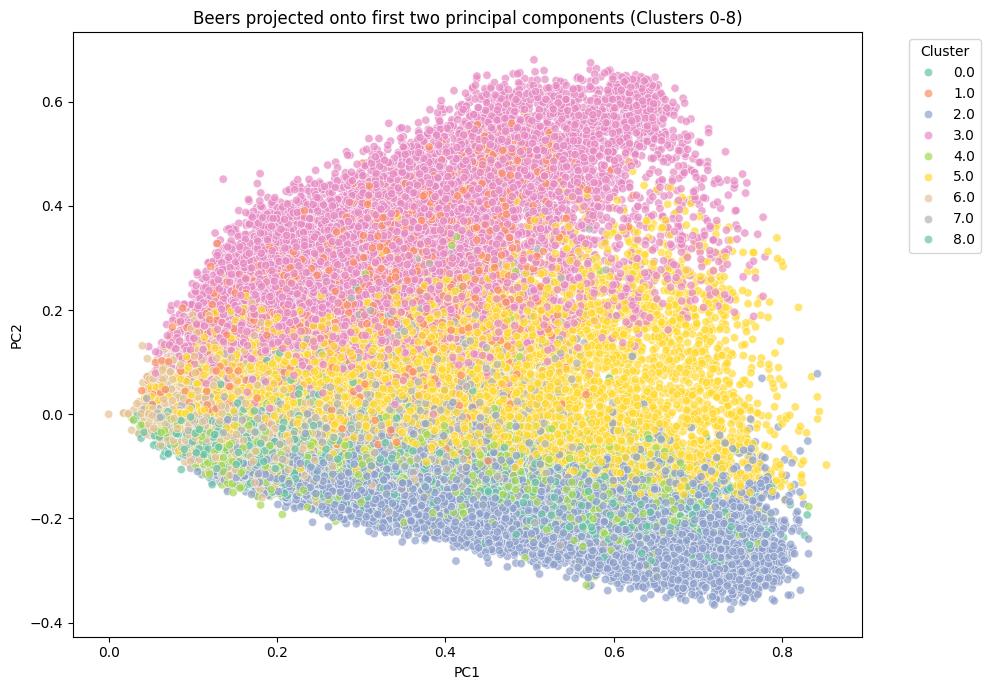

In [9]:
# -------------------------
# Visualization of First Two PCs
# -------------------------
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="cluster", data=beer_texts, palette="Set2", alpha=0.7,
    edgecolor="white", linewidth=0.5
)
plt.title("Beers projected onto first two principal components (Clusters 0-8)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
# -------------------------
# Inspecting Top Terms for Each PC
# -------------------------
terms = np.array(vectorizer.get_feature_names_out())

for i in range(n_components):
    comp = svd.components_[i]
    sorted_idx = np.argsort(comp)[::-1]
    top_positive_terms = terms[sorted_idx[:20]]
    top_negative_terms = terms[sorted_idx[-20:]]
    print(f"\nPrincipal Component {i+1} Interpretation")
    print("Top positively contributing terms:", top_positive_terms)
    print("Top negatively contributing terms:", top_negative_terms)


Principal Component 1 Interpretation
Top positively contributing terms: ['hops' 'dark' 'hop' 'little' 'flavor' 'caramel' 'citrus' 'notes'
 'chocolate' 'bottle' 'brown' 'just' 'really' 'bitterness' 'pours'
 'bitter' 'malts' 'orange' 'coffee' 'glass']
Top negatively contributing terms: ['sipping beer' 'sn' 'chimay' 'perfection' 'glarus' 'pumpkin beer'
 'sniftera pours' 'ab' 'new glarus' 'fresh bottle' 'russian river' 'pliny'
 'black night' 'stones' 'boulevard' 'pumpkin spice' 'sculpin'
 'southern tier' 'samuel adams' 'arrogant']

Principal Component 2 Interpretation
Top positively contributing terms: ['chocolate' 'coffee' 'dark' 'roasted' 'black' 'stout' 'brown' 'vanilla'
 'bourbon' 'tan' 'porter' 'dark brown' 'roast' 'dark chocolate'
 'roasted malt' 'cocoa' 'tan head' 'roasty' 'barrel' 'milk']
Top negatively contributing terms: ['amber' 'hoppy' 'clear' 'crisp' 'wheat' 'yellow' 'hazy' 'floral'
 'tropical' 'lemon' 'white head' 'pine' 'golden' 'grapefruit' 'pale' 'hop'
 'ipa' 'orange' 'ho

In [11]:
# -------------------------
# Cluster Separation by PCs
# -------------------------
cluster_means = beer_texts.groupby("cluster")[[f"PC{i+1}" for i in range(n_components)]].mean()
print("\nMean principal component scores by cluster (0-8):")
print(cluster_means)


Mean principal component scores by cluster (0-8):
              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
cluster                                                                         
0.0      0.249053 -0.080032 -0.017682 -0.069967  0.038991  0.061582  0.005178   
1.0      0.262984  0.189522 -0.085679  0.116146 -0.155535  0.174491 -0.148607   
2.0      0.379506 -0.149562  0.128452  0.065387 -0.018421  0.000803  0.000122   
3.0      0.292106  0.269329  0.050015  0.011941  0.072518 -0.003838  0.010615   
4.0      0.263478 -0.082743 -0.103096  0.029240  0.074446 -0.061853 -0.069044   
5.0      0.286028  0.037230 -0.024730 -0.064091 -0.082715 -0.047946  0.007292   
6.0      0.162790 -0.032305  0.010795  0.005012  0.005087  0.005957  0.000144   
7.0      0.227468 -0.026946 -0.146283  0.101795 -0.000715  0.010981  0.133357   
8.0      0.237599 -0.054014 -0.056930 -0.032819  0.018249  0.008775 -0.022155   

              PC8  
cluster            
0.0      0.000579

# Principal Components Analysis


### PC1: Generic, flavor-focused beers (positive) vs. famous, specialty, or seasonal beers (negative).

**Question: "When choosing a beer, do you focus more on general flavor profiles (citrus, chocolate, coffee) or do you seek out famous, specialty, or seasonal releases?"**

Slider meaning: -2 = strongly prefer famous/specialty; +2 = strongly prefer general flavor profiles.

### PC2: Dark, roasted stouts/porters (positive) vs. lighter, hoppier beers like pale ales/IPAs (negative).

**Question: "Do you prefer rich, dark, roasted stouts and porters, or lighter, hoppy beers like IPAs?"**

Slider: -2 = strongly prefer IPAs/hoppy pale beers; +2 = strongly prefer dark, roasted stouts.

### PC3: Hop-driven, bitter IPAs (positive) vs. sour, funky, fruity Belgian-style beers (negative).

**Question: "Are you more into hoppy, bitter IPAs or sour, funky Belgian-style beers?"**

Slider: -2 = strongly prefer sour/funky Belgian beers; +2 = strongly prefer bitter IPAs.

### PC4: Complex, citrusy, and sometimes barrel/sour beers (positive) vs. simpler, grain-forward lagers/ales (negative).

**Question: "Do you enjoy complex, citrusy, possibly barrel-aged/sour beers, or do you prefer simpler, grain-forward lagers and ales?"**

Slider: -2 = strongly prefer simple, grain-forward beers; +2 = strongly prefer complex, citrusy/sour beers.

### PC5: Lighter wheat or coffee-accented beers (positive) vs. richer, sweeter malt-heavy styles like barleywines (negative).

**Question: "Do you lean towards lighter wheat or coffee notes in your beer, or richer, sweeter, malt-heavy styles like barleywines?"**

Slider: -2 = strongly prefer sweeter barleywine-like styles; +2 = strongly prefer lighter wheat/coffee-accented beers.

### PC6: Subtle barrel-aged, vanilla/oak-influenced (positive) vs. spicy, Belgian/pumpkin-influenced beers (negative).

**Question: "Do subtle barrel-aged and vanilla/oak flavors appeal to you more than spicy, Belgian-influenced or pumpkin-flavored beers?"**

Slider: -2 = strongly prefer spicy/Belgian/pumpkin beers; +2 = strongly prefer barrel-aged, vanilla/oak notes.

### PC7: Tart, funky, sour beers (positive) vs. spicy, wheat-driven Belgian styles (negative).

**Question: "Are you more drawn to tart, funky, sour beers or to spicy, wheat-driven Belgian-style beers?"**

Slider: -2 = strongly prefer spicy/wheat-driven Belgian beers; +2 = strongly prefer tart, funky sours.

### PC8: Sensitivity to subtle mouthfeel and aroma details (positive) vs. more straightforward style and flavor focus (negative).

**Question: "Do you pay close attention to subtle mouthfeel and aroma details, or do you mainly care about straightforward, recognizable beer styles and flavors?"**

Slider: -2 = strongly prefer straightforward style/flavor; +2 = strongly prefer subtle mouthfeel/aroma nuances.

# Recommendation system

In [7]:
import numpy as np

# we have the following explained variance ratios from PCA:
explained_variance_ratios = np.array([0.02226398, 0.02605252, 0.01179182, 0.00950902,
                                      0.00892355, 0.00662831, 0.0061859, 0.00530022])

# Cluster means from the analysis (PC1 through PC8)
cluster_means = {
    0: [0.249053, -0.080032, -0.017682, -0.069967,  0.038991,  0.061582,  0.005178,  0.000579],
    1: [0.262984,  0.189522, -0.085679,  0.116146, -0.155535,  0.174491, -0.148607,  0.021532],
    2: [0.379506, -0.149562,  0.128452,  0.065387, -0.018421,  0.000803,  0.000122, -0.005868],
    3: [0.292106,  0.269329,  0.050015,  0.011941,  0.072518, -0.003838,  0.010615, -0.002157],
    4: [0.263478, -0.082743, -0.103096,  0.029240,  0.074446, -0.061853, -0.069044, -0.006481],
    5: [0.286028,  0.037230, -0.024730, -0.064091, -0.082715, -0.047946,  0.007292,  0.005726],
    6: [0.162790, -0.032305,  0.010795,  0.005012,  0.005087,  0.005957,  0.000144,  0.014120],
    7: [0.227468, -0.026946, -0.146283,  0.101795, -0.000715,  0.010981,  0.133357,  0.003663],
    8: [0.237599, -0.054014, -0.056930, -0.032819,  0.018249,  0.008775, -0.022155,  0.006228]
}

clusters = np.array(list(cluster_means.keys()))
mean_vectors = np.array(list(cluster_means.values()))

# Compute mean and std across clusters to standardize data.
pc_mean = mean_vectors.mean(axis=0)
pc_std = mean_vectors.std(axis=0, ddof=1)
# Ensure no division by zero
pc_std[pc_std == 0] = 1.0

# Compute weights for each dimension from explained variance.
dimension_weights = np.sqrt(explained_variance_ratios)

# Example user answers (from UI sliders, -2 to 2)
user_answers = {
    "PC1": 1.5,
    "PC2": -1.0,
    "PC3": 2.0,
    "PC4": 0.0,
    "PC5": -1.5,
    "PC6": 1.0,
    "PC7": -0.5,
    "PC8": 2.0,
}

# Validate user input
for k, v in user_answers.items():
    if not (isinstance(v, (int, float)) and -2 <= v <= 2):
        raise ValueError(f"Slider value for {k} must be a number between -2 and 2.")

# Convert user answers to array
user_vector = np.array(
    [
        user_answers["PC1"],
        user_answers["PC2"],
        user_answers["PC3"],
        user_answers["PC4"],
        user_answers["PC5"],
        user_answers["PC6"],
        user_answers["PC7"],
        user_answers["PC8"],
    ]
)

# Standardize cluster means and user vector using pc_mean and pc_std
standardized_mean_vectors = (mean_vectors - pc_mean) / pc_std
standardized_user_vector = (
    user_vector  # interpreted as std dev offsets from mean
)

# Weighted space transformation
weighted_mean_vectors = standardized_mean_vectors * dimension_weights
weighted_user_vector = standardized_user_vector * dimension_weights

# Euclidean distances in the weighted space
dists = np.linalg.norm(weighted_mean_vectors - weighted_user_vector, axis=1)

closest_cluster = clusters[np.argmin(dists)]

print("User's answers (raw):", user_vector)
# print("Cluster means (raw):", mean_vectors)
print("Mean of PCs across clusters:", pc_mean)
print("Std of PCs across clusters:", pc_std)
# print("Standardized cluster means:", standardized_mean_vectors)
print("User vector (interpreted as std units):", standardized_user_vector)
print("Weights (sqrt of explained variance ratios):", dimension_weights)
print("Distances to each cluster (weighted standardized):", dict(zip(clusters, dists)))
print("The user is closest to cluster:", closest_cluster)

User's answers (raw): [ 1.5 -1.   2.   0.  -1.5  1.  -0.5  2. ]
Mean of PCs across clusters: [ 0.26233467  0.007831   -0.02723756  0.01807156 -0.00534389  0.01655022
 -0.00923311  0.00414911]
Std of PCs across clusters: [0.05819325 0.1367472  0.08364705 0.06735276 0.07398987 0.06905371
 0.07462531 0.00918207]
User vector (interpreted as std units): [ 1.5 -1.   2.   0.  -1.5  1.  -0.5  2. ]
Weights (sqrt of explained variance ratios): [0.14921119 0.16140793 0.10859015 0.0975142  0.09446454 0.08141443
 0.07865049 0.07280261]
Distances to each cluster (weighted standardized): {0: 0.4487194685105029, 1: 0.5672606278357732, 2: 0.30010384076146673, 3: 0.6062966296874422, 4: 0.5427919530868945, 5: 0.4153712808470736, 6: 0.5574154877501134, 7: 0.5943742402919819, 8: 0.4649821060880616}
The user is closest to cluster: 2
